In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Functions to be used later

def line_multiplication_class_balancing(df, dupe_amount):
    ''' Function to balance the classes by duplicating rows with a 1 in either PKM2_inhibition or ERK2_inhibition

    Parameters:
    df: DataFrame with the data (DataFrame)
    dupe_amount: Amount of rows to duplicate (int)
    Returns:
    balanced_df: DataFrame with the duplicated rows (DataFrame) '''
    ones_filter = (df['PKM2_inhibition'] == 1) | (df['ERK2_inhibition'] == 1)
    filtered_df = df[ones_filter]
    random_selection = np.random.choice(filtered_df.index, size=dupe_amount, replace=True)
    duped_rows = df.loc[random_selection]
    balanced_df = pd.concat([df, duped_rows], ignore_index=True)
    return balanced_df

def balanced_accuracy_score(y_true, y_pred):
    ''' Function to calculate the balanced accuracy score

    Parameters:
    y_true: True labels (list)
    y_pred: Predicted labels (list)
    Returns:
    balanced_accuracy: Balanced accuracy score (float) '''
    cm = confusion_matrix(y_true, y_pred)
    num_classes = cm.shape[0]
    sensitivities = []

    for i in range(num_classes):
        true_positives = cm[i, i]
        actual_positives = cm[i, :].sum()
        sensitivity = true_positives / actual_positives
        sensitivities.append(sensitivity)

    balanced_accuracy = sum(sensitivities) / num_classes
    return balanced_accuracy

def cm_plot(y_true, y_pred, class_name):
    ''' Function to plot a confusion matrix

    Parameters:
    y_true: True labels (list)
    y_pred: Predicted labels (list)
    class_name: Name of the class (str) '''
    # Calculate balanced accuracy
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 4))
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    
    # Title with class name and balanced accuracy
    plt.title(f"Confusion Matrix for {class_name} inhibition\nBalanced Accuracy: {balanced_acc:.2f}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()


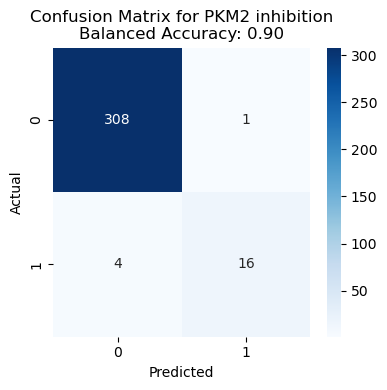

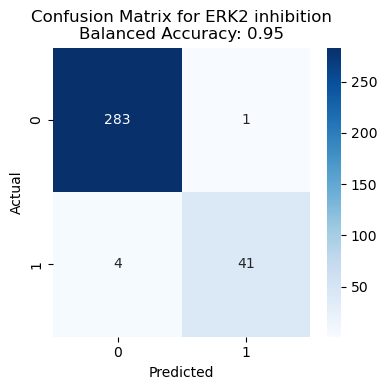

Number of times 1 is predicted for PKM2: 24
Number of times 1 is predicted for ERK2: 24


In [14]:
# Load the data
file_path = r"Data/Train set with descriptors.csv"
df = pd.read_csv(file_path)

# Balance the dataset by duplicating rows with 1 in the target variables
balanced_df = line_multiplication_class_balancing(df, 200)

# Select the first 20 features and the target variables
X = balanced_df.iloc[:, :20]
selected_features = X.columns.tolist()

# Split the target variables
y_pkm2 = balanced_df['PKM2_inhibition']
y_erk2 = balanced_df['ERK2_inhibition']

# Convert data to float32
X = X.astype(np.float32)
y_pkm2 = y_pkm2.astype(np.float32)
y_erk2 = y_erk2.astype(np.float32)

# Split the data for PKM2
X_train_pkm2, X_test_pkm2, y_train_pkm2, y_test_pkm2 = train_test_split(
    X, y_pkm2, test_size=0.25, random_state=42
)

# Split the data for ERK2
X_train_erk2, X_test_erk2, y_train_erk2, y_test_erk2 = train_test_split(
    X, y_erk2, test_size=0.25, random_state=42
)

# Create and train the RandomForestClassifier for PKM2
clf_pkm2 = RandomForestClassifier(n_estimators=10, random_state=42)
clf_pkm2.fit(X_train_pkm2, y_train_pkm2)

# Create and train the RandomForestClassifier for ERK2
clf_erk2 = RandomForestClassifier(n_estimators=10, random_state=42)
clf_erk2.fit(X_train_erk2, y_train_erk2)

# Make predictions on the test set for PKM2 and ERK2
y_pred_pkm2 = clf_pkm2.predict(X_test_pkm2)
y_pred_erk2 = clf_erk2.predict(X_test_erk2)

# Adding the actual and predicted values to a new dataframe
results_df = pd.DataFrame({
    'PKM2_actual': y_test_pkm2,
    'ERK2_actual': y_test_erk2,
    'PKM2_predicted': y_pred_pkm2,
    'ERK2_predicted': y_pred_erk2
})

# Plot confusion matrix for PKM2 inhibition
cm_plot(y_test_pkm2, y_pred_pkm2, class_name='PKM2')

# Plot confusion matrix for ERK2 inhibition
cm_plot(y_test_erk2, y_pred_erk2, class_name='ERK2')

# Read in new csv with untested molecules
test_df = pd.read_csv("Data/Test set with descriptors.csv")

# Select the columns corresponding to the selected features
X_test = test_df[selected_features]
X_test = X_test.astype(np.float32)

# Use the trained models to predict the inhibitions
y_pred_test_pkm2 = clf_pkm2.predict(X_test).astype(int)
y_pred_test_erk2 = clf_erk2.predict(X_test).astype(int)

# Creating a new dataframe with the SMILES and predicted inhibition values
results_new_df = pd.DataFrame({
    'SMILES': test_df['SMILES'],
    'PKM2_predicted': y_pred_test_pkm2,
    'ERK2_predicted': y_pred_test_erk2
})

# Save the predictions to a new CSV file
output_new_file_path = "Results\predictions_rf_desc.csv"
results_new_df.to_csv(output_new_file_path, index=False)

# Count the number of times 1 is predicted in PKM2_predicted and ERK2_predicted
pkm2_count = (results_new_df['PKM2_predicted'] == 1).sum()
erk2_count = (results_new_df['ERK2_predicted'] == 1).sum()

print(f"Number of times 1 is predicted for PKM2: {pkm2_count}")
print(f"Number of times 1 is predicted for ERK2: {erk2_count}")


PKM2 Model Accuracy: 0.993920972644377
ERK2 Model Accuracy: 0.9908814589665653
PKM2 Model Balanced Accuracy: 0.9375
ERK2 Model Balanced Accuracy: 0.9864157706093191


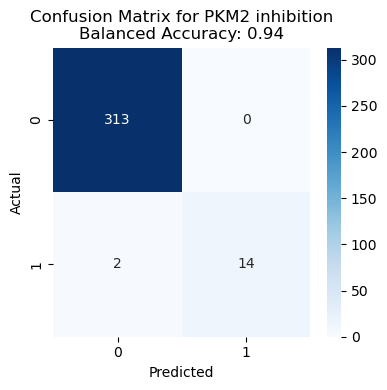

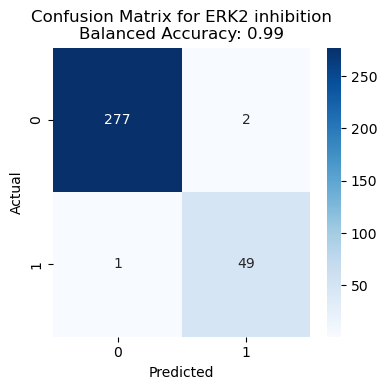

Predictions saved to 'Results\predictions_rf_keys.csv'
PKM2 Inhibition Predictions: 17
ERK2 Inhibition Predictions: 26


In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the train dataset
train_path = 'Data/Train set with MACCS keys.csv'
train_data = pd.read_csv(train_path)


train_data = line_multiplication_class_balancing(train_data, 200)

# Function to convert bitstring into a list of integers
def bitstring_to_list(bitstring):
    return [int(bit) for bit in bitstring.strip('[]').split(', ')]

# Convert MACCS keys bitstrings into lists of integers for the train set
train_data['maccs_keys_list'] = train_data['maccs_keys_bitstring'].apply(bitstring_to_list)

# Extract features and target variables
X = np.array(train_data['maccs_keys_list'].tolist())
y_pkm2 = train_data['PKM2_inhibition']
y_erk2 = train_data['ERK2_inhibition']

# Split the data
X_train, X_val, y_train_pkm2, y_val_pkm2 = train_test_split(X, y_pkm2, test_size=0.25, random_state=42)
_, _, y_train_erk2, y_val_erk2 = train_test_split(X, y_erk2, test_size=0.25, random_state=42)

# Train Random Forest models
rf_pkm2 = RandomForestClassifier(n_estimators=10, random_state=42)
rf_erk2 = RandomForestClassifier(n_estimators=10, random_state=42)

rf_pkm2.fit(X_train, y_train_pkm2)
rf_erk2.fit(X_train, y_train_erk2)

# Evaluate the models
y_pred_val_pkm2 = rf_pkm2.predict(X_val)
y_pred_val_erk2 = rf_erk2.predict(X_val)

accuracy_pkm2 = accuracy_score(y_val_pkm2, y_pred_val_pkm2)
accuracy_erk2 = accuracy_score(y_val_erk2, y_pred_val_erk2)

print("PKM2 Model Accuracy:", accuracy_pkm2)
print("ERK2 Model Accuracy:", accuracy_erk2)

# Calculate and print balanced accuracy
balanced_accuracy_pkm2 = balanced_accuracy_score(y_val_pkm2, y_pred_val_pkm2)
balanced_accuracy_erk2 = balanced_accuracy_score(y_val_erk2, y_pred_val_erk2)

print("PKM2 Model Balanced Accuracy:", balanced_accuracy_pkm2)
print("ERK2 Model Balanced Accuracy:", balanced_accuracy_erk2)

# Plot confusion matrices
cm_plot(y_val_pkm2, y_pred_val_pkm2, "PKM2")
cm_plot(y_val_erk2, y_pred_val_erk2, "ERK2")

# Load the test dataset
test_path = 'Data/Test set with MACCS keys.csv'
test_data = pd.read_csv(test_path)

# Convert MACCS keys bitstrings into lists of integers for the test set
test_data['maccs_keys_list'] = test_data['maccs_keys_bitstring'].apply(bitstring_to_list)

# Extract features
X_test = np.array(test_data['maccs_keys_list'].tolist())

# Make predictions on the test set
y_test_pred_pkm2 = rf_pkm2.predict(X_test)
y_test_pred_erk2 = rf_erk2.predict(X_test)

# Adding the predicted values to the test dataframe
test_data['PKM2_predicted'] = y_test_pred_pkm2
test_data['ERK2_predicted'] = y_test_pred_erk2

# Select only the required columns
output_df = test_data[['SMILES', 'PKM2_predicted', 'ERK2_predicted']]

# Save predictions to new CSV
output_test_file_path = "Results\predictions_rf_keys.csv"
output_df.to_csv(output_test_file_path, index=False)

print(f"Predictions saved to '{output_test_file_path}'")

# count the number of times a 1 is predicted
pkm2_count = np.count_nonzero(y_test_pred_pkm2)
erk2_count = np.count_nonzero(y_test_pred_erk2)

print(f"PKM2 Inhibition Predictions: {pkm2_count}")
print(f"ERK2 Inhibition Predictions: {erk2_count}")


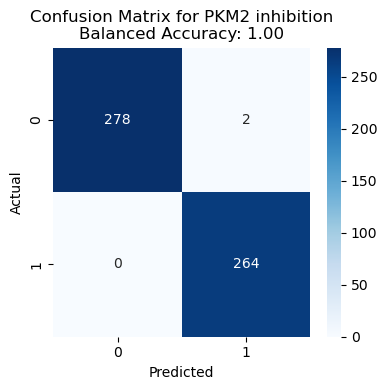

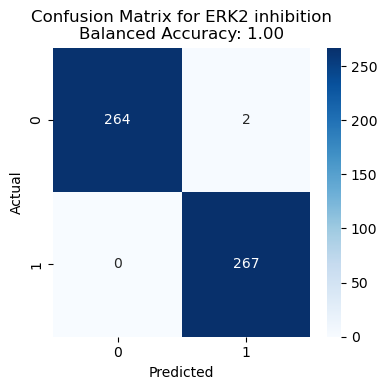

Number of times 1 is predicted for PKM2: 13
Number of times 1 is predicted for ERK2: 17


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the data
file_path = r"Data/Train set with descriptors.csv"
df = pd.read_csv(file_path)

# Select the first 20 features and the target variables
X = df.iloc[:, :20]
selected_features = X.columns.tolist()

# Split the target variables
y_pkm2 = df['PKM2_inhibition']
y_erk2 = df['ERK2_inhibition']

# Convert data to float32
X = X.astype(np.float32)
y_pkm2 = y_pkm2.astype(np.float32)
y_erk2 = y_erk2.astype(np.float32)

# Perform Random Oversampling for PKM2
ros_pkm2 = RandomOverSampler(random_state=42)
X_resampled_pkm2, y_resampled_pkm2 = ros_pkm2.fit_resample(X, y_pkm2)

# Perform Random Oversampling for ERK2
ros_erk2 = RandomOverSampler(random_state=42)
X_resampled_erk2, y_resampled_erk2 = ros_erk2.fit_resample(X, y_erk2)

# Split the data for PKM2
X_train_pkm2, X_test_pkm2, y_train_pkm2, y_test_pkm2 = train_test_split(
    X_resampled_pkm2, y_resampled_pkm2, test_size=0.25, random_state=42
)

# Split the data for ERK2
X_train_erk2, X_test_erk2, y_train_erk2, y_test_erk2 = train_test_split(
    X_resampled_erk2, y_resampled_erk2, test_size=0.25, random_state=42
)

# Create and train the RandomForestClassifier for PKM2
clf_pkm2 = RandomForestClassifier(n_estimators=10, random_state=42)
clf_pkm2.fit(X_train_pkm2, y_train_pkm2)

# Create and train the RandomForestClassifier for ERK2
clf_erk2 = RandomForestClassifier(n_estimators=10, random_state=42)
clf_erk2.fit(X_train_erk2, y_train_erk2)

# Make predictions on the test set for PKM2 and ERK2
y_pred_pkm2 = clf_pkm2.predict(X_test_pkm2)
y_pred_erk2 = clf_erk2.predict(X_test_erk2)

# Plot confusion matrix for PKM2 inhibition
cm_plot(y_test_pkm2, y_pred_pkm2, class_name='PKM2')

# Plot confusion matrix for ERK2 inhibition
cm_plot(y_test_erk2, y_pred_erk2, class_name='ERK2')

# Read in new csv with untested molecules
test_df = pd.read_csv("Data/Test set with descriptors.csv")

# Select the columns corresponding to the selected features
X_test = test_df[selected_features]
X_test = X_test.astype(np.float32)

# Use the trained models to predict the inhibitions
y_pred_test_pkm2 = clf_pkm2.predict(X_test).astype(int)
y_pred_test_erk2 = clf_erk2.predict(X_test).astype(int)

# Creating a new dataframe with the SMILES and predicted inhibition values
results_new_df = pd.DataFrame({
    'SMILES': test_df['SMILES'],  # Assuming 'SMILES' is the column name for molecule representations
    'PKM2_predicted': y_pred_test_pkm2,
    'ERK2_predicted': y_pred_test_erk2
})

# Save the predictions to a new CSV file
output_new_file_path = "Results\predictions_rf_desc.csv"
results_new_df.to_csv(output_new_file_path, index=False)

# Count the number of times 1 is predicted in PKM2_predicted and ERK2_predicted
pkm2_count = (results_new_df['PKM2_predicted'] == 1).sum()
erk2_count = (results_new_df['ERK2_predicted'] == 1).sum()

print(f"Number of times 1 is predicted for PKM2: {pkm2_count}")
print(f"Number of times 1 is predicted for ERK2: {erk2_count}")
